In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import TFElectraModel
from transformers import ElectraTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
strategy = tf.distribute.get_strategy()

In [3]:
train = pd.read_csv("data/train.csv", encoding="UTF8")
test = pd.read_csv("data/test.csv", encoding="UTF8")

In [4]:
train['cat1'].unique()

array(['자연', '레포츠', '음식', '인문(문화/예술/역사)', '숙박', '쇼핑'], dtype=object)

In [5]:
print(f"number of cat1 : {len(train['cat1'].unique())}")
print(f"number of cat2 : {len(train['cat2'].unique())}")
print(f"number of cat3 : {len(train['cat3'].unique())}")

number of cat1 : 6
number of cat2 : 18
number of cat3 : 128


In [6]:
for i in range(len(train)):
    train['overview'][i] = train['overview'][i].replace('\n','').replace('\t','').replace('\r','').replace('<br>', '').replace('<br />','').replace('*','')
    train['overview'][i] = train['overview'][i].strip()

In [7]:
encoder = LabelEncoder()

encoder.fit(train['cat1'])
train['cat1'] = encoder.transform(train['cat1'])

In [8]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [9]:
train_data = train['overview'].values.tolist()

In [10]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (1232 > 512). Running this sequence through the model will result in indexing errors


In [11]:
cal_length = train_encoded_electra['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 181.22842340751208
토큰 길이 최대: 4516
토큰 길이 표준편차: 156.32824911587227
설정 최대 길이: 493
전체 문장의 0.9612033439302955%가 설정값인 493에 포함됩니다.


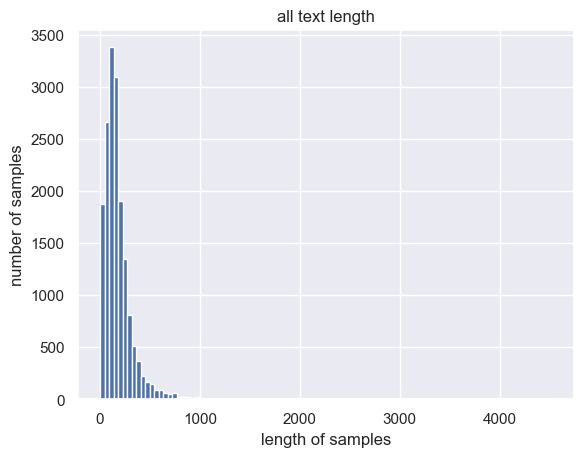

In [12]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(4,3))
plt.title('all text length')
plt.hist(num_tokens, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
select_length = 500

In [14]:
len(train)

16986

In [15]:
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    train.drop(train.index[i], inplace=True)

In [16]:
len(train)

16342

In [17]:
train_data = train['overview'].values.tolist()

In [18]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)

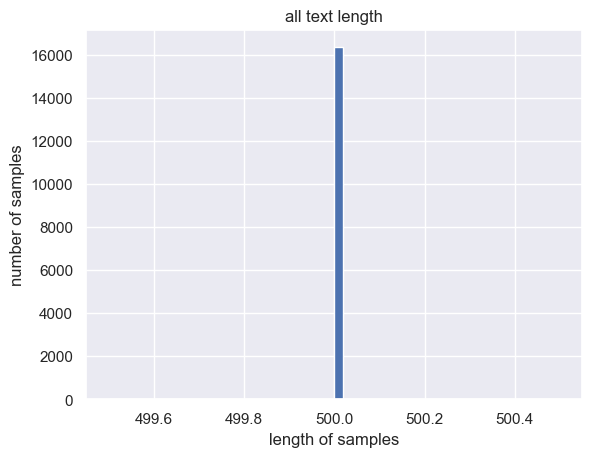

In [47]:
cal_length = train_encoded_electra['input_ids']
num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

plt.figure(figsize=(4,3))
sns.set_theme(style="darkgrid")
plt.title('all text length')
plt.hist(num_tokens, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=500)

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.cat1.values, test_size=0.2, random_state=777)

In [22]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(4 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(4 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [23]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(500,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(6, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


C:\Users\Home\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 500)]             0         
_________________________________________________________________
tf_electra_model (TFElectraM TFBaseModelOutputWithPast 112330752 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 4614      
Total params: 112,335,366
Trainable params: 112,335,366
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train_dataset,steps_per_epoch=len(train) // 4 * strategy.num_replicas_in_sync,
                    validation_data=valid_dataset,epochs= 5)

Epoch 1/5
4085/4085 [==============================] - 1137s 276ms/step - loss: 0.5112 - accuracy: 0.8225 - val_loss: 0.2915 - val_accuracy: 0.9110
Epoch 2/5
4085/4085 [==============================] - 1127s 276ms/step - loss: 0.2725 - accuracy: 0.9078 - val_loss: 0.2638 - val_accuracy: 0.9263
Epoch 3/5
4085/4085 [==============================] - 1128s 276ms/step - loss: 0.1507 - accuracy: 0.9519 - val_loss: 0.2663 - val_accuracy: 0.9263
Epoch 4/5
4085/4085 [==============================] - 1128s 276ms/step - loss: 0.1033 - accuracy: 0.9688 - val_loss: 0.2648 - val_accuracy: 0.9324
Epoch 5/5
4085/4085 [==============================] - 1127s 276ms/step - loss: 0.0723 - accuracy: 0.9780 - val_loss: 0.2742 - val_accuracy: 0.9284


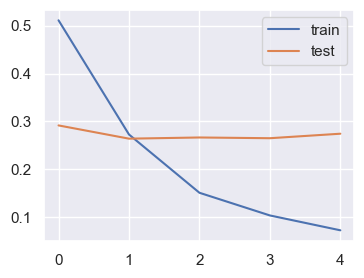

In [29]:
plt.figure(figsize=(4,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

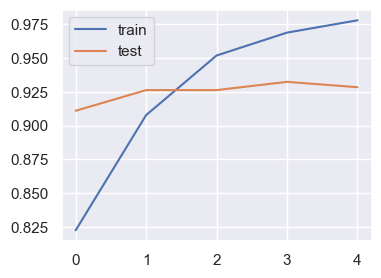

In [30]:
plt.figure(figsize=(4,3))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [34]:
from tensorflow import keras

In [43]:
model.save_weights('checkpoints/koelectra/koelectra_checkpoint')

In [44]:
saved_model = model_KoELECTRA()
saved_model.load_weights('checkpoints/koelectra/koelectra_checkpoint')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [45]:
loss,acc = model.evaluate(valid_dataset, verbose=1)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

818/818 [==============================] - 75s 91ms/step - loss: 0.2742 - accuracy: 0.9284
복원된 모델의 정확도: 92.84%
